# RL coursework, part I (20 pts total)
---

**Name:** Ana Kapros

**SN:** 19018725

---

**Due date:** *27th March, 2023*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [43]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [44]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [45]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [46]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [47]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

### Common Functions to be used by all MAB agents

In [48]:
def update_values(agent, previous_action, reward):
    # increase visits of previous_action
    agent.N[previous_action] += 1
    alpha = 1/agent.N[previous_action] 
    # the Q value of previous_action is the mean of rewards received so far by pulling that action
    agent.Q[previous_action] = (1-alpha)*agent.Q[previous_action] + alpha * reward

def maxQ_actions_non_vectorized(agent, Q):
    optimal_actions = []
    max_Q = None
    for a in range(agent._number_of_arms):
      if (max_Q is None) or (max_Q < Q[a]):
        max_Q = Q[a]
        optimal_actions = [a]
      elif max_Q == Q[a]:
        optimal_actions.append(a)
    return optimal_actions

def maxQ_actions(agent, Q):
    optimal_actions = np.argwhere(Q == np.amax(Q)).flatten()
    assert (np.array_equal(np.array(optimal_actions), maxQ_actions_non_vectorized(agent, Q)))
    return optimal_actions

def reset_agent(agent):
    agent.t = 0
    agent.Q = np.zeros(agent._number_of_arms)
    agent.N = np.zeros(agent._number_of_arms)

In [49]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    self.t += 1
    if previous_action is not None:
      update_values(agent=self, previous_action=previous_action, reward=reward)
    if self.t <= self._number_of_arms:
      # This ensures the count for each arm is nonzero, at time step self._number_of_arms + 1,
      return self.t - 1
    
    Q_plus_UCB = np.copy(self.Q)
    for a in range(self._number_of_arms):
      Q_plus_UCB[a] += self._bonus_multiplier * np.sqrt(np.log(self.t) / self.N[a])
    optimal_actions = maxQ_actions(self, Q=Q_plus_UCB)
    return np.random.choice(optimal_actions)

  def reset(self):
    reset_agent(self)

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [50]:
import types
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms
    self.epsilon = epsilon
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    self.t += 1
    if previous_action is not None:
      update_values(agent=self, previous_action=previous_action, reward=reward)

    epsilon_t = self.epsilon
    if isinstance(self.epsilon, types.FunctionType):
      epsilon_t = self.epsilon(self.t)

    # Select action  
    if np.random.random() <= epsilon_t:
      # With probability epsilon_t select action uniformly at random 
      return np.random.choice(self._number_of_arms)
    
    # Select uniformly from the optimal actions w.p. 1 - epsilon_t
    optimal_actions = maxQ_actions(agent=self, Q=self.Q)
    return np.random.choice(optimal_actions)

  def reset(self):
    reset_agent(self)

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


As defined in Lecture 2 slide 25, the update for policy gradients is given as $\theta = \theta + \alpha \nabla_{\theta} R_t$, where $\theta$ represents the parameters for the policy $\pi_{\theta}$, $\alpha$ is the step size and $R_t$ is the reward at time $t$. Using the log-likelihood trick, the update becomes: 
$\theta = \theta + \alpha R_t \nabla_{\theta} \log{\pi_{\theta}(A_t)}$ 

Deriving for the squaremax:

$\log{\pi_{\theta}(A_t)} = \log{(\frac{p(A_t)^2}{\sum_b p(b)^2})} = 2 \log{p(A_t)} - \log{(\sum_b p(b)^2)}$

Becuase the policy is parametrised by p, $\theta = p$, and the updates to the individual components (i.e. actions) is:

$p_{t+1}(a) = p_{t}(a) + \alpha R_t \frac{\delta}{\delta{p_t(a)}}{\log{\pi_{\theta}(A_t)}}$

$\frac{\delta}{\delta{p_t(a)}}{\log{\pi_{\theta}(A_t)}} = \frac{\delta}{\delta{p_t(a)}}{\left ( 2 \log{p(A_t)} - \log{\sum_b p(b)^2} \right )} = \frac{2}{p_t(A_t)} \frac{\delta}{\delta{p_t(a)}}{p_t(A_t)} - \frac{2p_t(a)}{\sum_b p(b)^2}$

For $a = A_t$, $\frac{\delta}{\delta{p_t(a)}}{\log{\pi_{\theta}(A_t)}} = \frac{2}{p_t(A_t)} - \frac{2p_t(a)}{\sum_b p(b)^2} = \frac{2}{p_t(A_t)} (1 - \pi_{t}(A_t))$, and the update is

$p_{t+1}(A_t) = p_{t}(A_t) + \alpha R_t (\frac{2}{p_t(A_t)} - \frac{2p_t(a)}{\sum_b p(b)^2})$

For $a \ne A_t$, $\frac{\delta}{\delta{p_t(a)}}{\log{\pi_{\theta}(A_t)}} = - \frac{2p_t(a)}{\sum_b p(b)^2} = \frac{-2}{p_t(a)} \pi_{t}(a)$, and the update is

$p_{t+1}(a) = p_{t}(a) + \alpha R_t (-\frac{2p_t(a)}{\sum_b p(b)^2})$

Using a baseline $X_t$ that doesn't depend on actions (e.g. the average reward received so far $X_t = \frac{\sum_{k=1}^{t}R_t}{t}$), we can simply subtract it from $R_t$ to reduce the magnitude of our updates to the gradient.



In [51]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self._number_of_arms = number_of_arms
    self._step_size = step_size
    self._baseline = baseline
    self.reset()

  def policy_from_preference(self):
    policy = np.copy(np.square(self._p))
    normalisation = np.sum(policy)
    return policy / normalisation
  
  def update_values_square_max(self, previous_action, reward):
    self._average_reward += (1 / self.t) * (reward - self._average_reward)
    policy_t = self.policy_from_preference()
    for a in range(self._number_of_arms):
      is_prev_act = 0
      if a == previous_action:
        is_prev_act = 1
      gradient = (2 / self._p[a]) * (is_prev_act - policy_t[a])
      if self._baseline:
        self._p[a] += self._step_size * (reward - self._average_reward) * gradient
      else:
        self._p[a] += self._step_size * reward * gradient

  def step(self, previous_action, reward):
    self.t += 1

    if previous_action is not None:
      self.update_values_square_max(previous_action=previous_action, reward=reward)
    # Select action according to stochastic policy derived from preference self._p
    return np.random.choice(a=self._number_of_arms, p=self.policy_from_preference())

  def reset(self):
    self._average_reward = 0
    self._p = np.random.random(size=self._number_of_arms) 
    reset_agent(self)

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [52]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

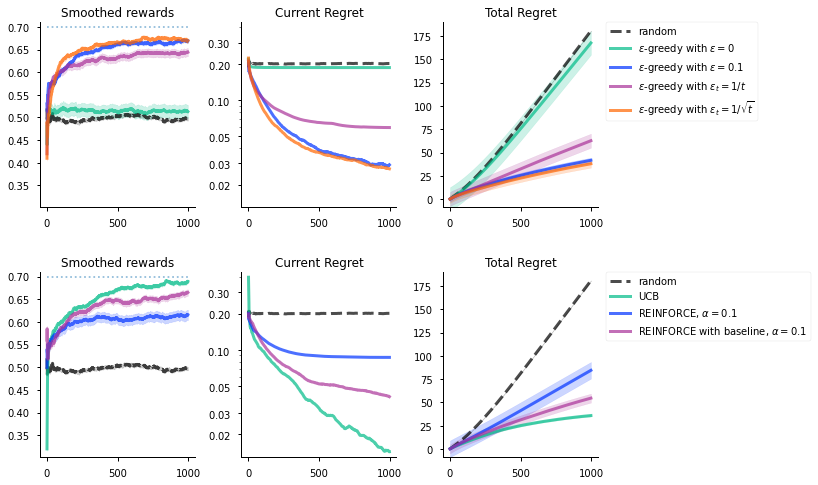

In [53]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

Because the setting is stationary, the speed of convergence to the **optimal** action is highly correlated with the performance.
#### $\epsilon$-Greedy
The $\epsilon$-Greedy algorithm has variable performance depending on $\epsilon$, as detailed in the second question. We should expect Greedy to perform poorly because it doesn't explore enough, with a high probability of not converging to the optimal action; $\epsilon$-Greedy for constant $\epsilon$ should perform well in the short term, but it has linear regret in the long term, while the 2 time-dependent $\epsilon$ values should converge to the optimal action(s) and achieve logarithmic regret.
 <!-- (?with the speed of convergence inverse proportional to $\epsilon$). -->
#### UCB
UCB has logarithmic regret, and it is known to converge to the optimal action. It should outperform $\epsilon$-Greedy because UCB explores actions that are likely to have the highest return (either because the actions are uncertain (not explored enough) or because they have a high mean) while $\epsilon$-Greedy doesn't distinguish between the non-greedy actions.
#### REINFORCE
REINFORCE uses stochastic gradient ascent, and it converges (under appropriate step sizes) to a local maximum. Because squaremax is continuous and convex, it has a unique maximum, and hence, REINFORCE will converge to the optimal action. The baseline, while not influencing the action converged to, should reduce variance, increasing the speed of convergence.


**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

The asymptotic regret of the greedy algorithm is linear in time, because the algorithm doesn't explore (enough), and it's very likely to converge to a suboptimal action, which is in agreement with the experiments, as greedy (i.e. the $\epsilon$-greedy algorithm with $\epsilon=0$) performs worse than all other $\epsilon$-greedy algorithms, with constant current regret. $\epsilon$-greedy with $\epsilon$ constant explores infinitely often, and it will have asymptotic linear regret. Yet, for shorter timeframes, it outperforms rapidly decaying $\epsilon$ values: the cumulative regret is lower than for $\frac{1}{t}$-greedy because the exploration is reduced too fast for the latter, while for at least the first few episodes, its cumulative regret is lower than for $\frac{1}{\sqrt{t}}$-greedy. The rapid decaying of exploration in $\frac{1}{t}$-greedy as compared to $\frac{1}{\sqrt{t}}$-greedy explains the lower cumulative regret of the latter. The ordering of algorithms in terms of rewards is also maintained. Finally, from the current regret plots, we observe that for greedy, the algorithm will have constant regret. For the 2 time-dependent $\epsilon$ greedy, convergence is guaranteed because the Robbins–Monro conditions are satisfied, yet, because $\frac{1}{t}$ decays too rapidly, the convergence is much slower. Even if convergence is not guaranteed by $\epsilon=0.1$, the performance is much better than for $\frac{1}{t}$-greedy.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [54]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

In [55]:
agents[-2]._p

array([-0.861, -0.109,  0.05 , -0.793, -3.435])

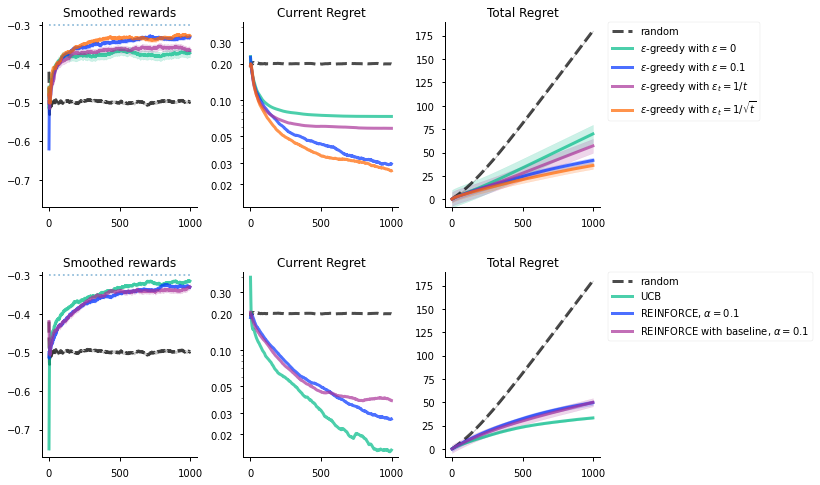

In [56]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

Because the reward decreased by 1 in the case of both failure and success, the distribution of rewards for each arm is just scaled by -1, with the optimality ordering and regrets of arms being unchanged compared to **experiment 1**. Yet, the initialisation to 0 of mean rewards per arm (and the initialisation of preferences to 0 for REINFORCE) gives rise to small differences. 

#### $\epsilon$-Greedy
The gap between Greedy and $\epsilon$-Greedy is smaller because all rewards are non-positive, and hence each arm will be selected at least once. Likewise, the difference between $\frac{1}{t}$-Greedy and $\frac{1}{\sqrt{t}}$-Greedy is slightly smaller due to more exploration.
#### UCB
For UCB, because we initially explore each action, and then apply the algorithm, the performance is unchanged, as the action selected is $argmax_{a} (Q^{(2)}_t(a) + U_t(a)) = argmax_{a} (Q^{(1)}_t(a) - 1 + U_t(a))$, where $Q^{(i)}_t(a)$ is the mean of rewards received on action $a$ until time $t$ in experiment $i$.

#### REINFORCE
Because the update for REINFORCE is $\theta = \theta + \alpha R_t \nabla_{\theta} \log{\pi_{\theta}(A_t)}$, scaling rewards by $-1$ only changes the magnitude of updates. As rewards are either 0 or 1 in experiment1, the update is non-zero only for success, while in experiment2, the update is non-zero for failure. REINFORCE without a baseline in the 5 Benroulli bandits setting learns faster from failures, as the regret is lower in experiment2.
When using a baseline, because all distributions are scaled by -1, the average reward will also be scaled by $-1$, giving rise to the same update in the 2 experiments, and hence, the same performance for REINFORCE with baseline.

## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [57]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [58]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

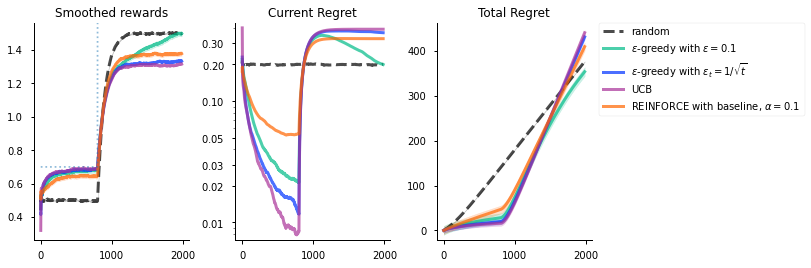

In [59]:
experiment3.show()

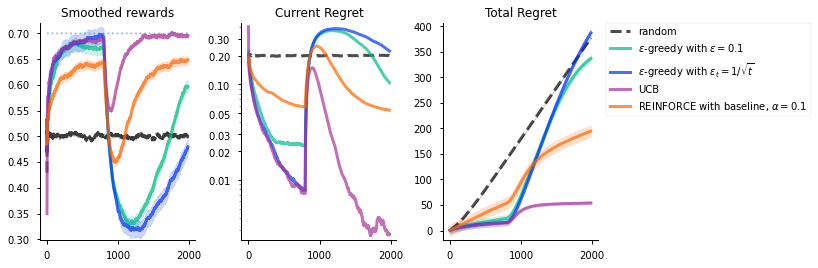

In [60]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> Because the change doesn't decrease the reward for success, but increases the reward for failure, the true mean of all arms increases. Moreover, arms with higher success rate will never decrease their q-values, even if after the change, the arms with lower regret are the ones with higher failure rate. 
Apart from random and $0.1$-Greedy, all algorithms converged to the optimal action(s) before the change. After the change, because the values of optimal arms will not decrease, UCB, choosing the action maximising $Q_t(a) + c \frac{\log{t}}{N_t(a)}$ will never update the values of arms with higher failure rate, while the 2 time-dependent $\epsilon$-Greedy models will select the now optimal arms with very low probability, and the increase in update for the value of these arms will also be slow. Because $0.1$-Greedy explores infinitely and does not converge, it eventually learns that the ordering of arms changes, resulting in better performance. The random algorithm performance is unchanged, but it has lower regret than the arms that converged prior to the change. Likewise for REINFORCE the actions $a$ most likely selected in the converged policy will have positive preferences $p(a)$, and the updates will be positive for selected actions (rewards will increase, with the baseline increasing at a similar rate and $R_t \ge 0$) and negative ($\alpha (R_t - baseline) (-\frac{2p_t(a)}{\sum_b p(b)^2})$) for not selected actions. Thus, the arms with a higher failure rate, which were suboptimal before the change, will not be selected, and the regret will increase, as these are the optimal arms after the change. 

**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> 
Because the value of success decreases, the value function of arms with a higher success rate decreases, eventually becoming lower than the value of arms with higher failure rate. At this point, actions with a higher failure rate will be selected more often, and eventually, the estimated q-value for them will converge to the true value, and these actions will be selected more often. This is true for all agents apart from the random one.

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> Because in experiment4 we decrease the value of success, eventually, the Q-value of arms with higher success
rates, which were optimal when the reward on success was greater than on failure, will become smaller than the Q-value of
the ones with a higher failure rate, after which point we will reselect those arms and increase their Q-value due to the
increase in failure reward. Eventually, the algorithm will stabilise on the arm with the highest failure rate. In experiment3,
because we don't change the success reward, the Qvalue of the arms with higher success rate will only increase, and not give the chance to the arms with higher failure rate to be selected (due to the low value of $Q_t(a) + c \frac{\log{t}}{N_t(a)}$) which would allow the agent to observe the change.

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> The easiest solution is to change the step size parameter to constant (i.e. instead of using $\alpha = \frac{1}{N_t}$, wherein the Q-value is estimated as the mean of rewards for that arm, using a constant $\alpha$ will give a higher weight for current rewards), which allows the agent to eventually forget the past, with the higher the value, the faster the agent "forgets" the past. Yet, if the values only increase, tracking does not solve the problem, and instead, we would need to reset periodically (e.g. every 100 steps) the number of selections for each arm, s.t. exploration allows detecting changes.
